In [1]:
import pandas as pd 

In [2]:
data_link = "data/crc_dataset.csv"
df = pd.read_csv(data_link)

In [3]:
df.head()

,Participant_ID,Age,Gender,BMI,Lifestyle,Ethnicity,Family_History_CRC,Pre-existing Conditions,Carbohydrates (g),Proteins (g),Fats (g),Vitamin A (IU),Vitamin C (mg),Iron (mg),CRC_Risk
0,1001,63,Female,21.6,Sedentary,Hispanic,Yes,Diabetes,245,98,41,4176,97,15.3,0
1,1002,76,Male,31.4,Smoker,Hispanic,No,Obesity,398,56,61,3400,38,9.5,1
2,1003,53,Female,24.3,Moderate Exercise,Asian,No,NaN,375,79,59,5104,51,14.4,0
3,1004,39,Male,19.5,Sedentary,Asian,Yes,NaN,325,98,64,6050,47,7.3,0
4,1005,67,Male,34.5,Moderate Exercise,Asian,No,Obesity,169,65,54,5233,105,12.0,0


In [4]:
df.isnull().sum()

Participant_ID               0
Age                          0
Gender                       0
BMI                          0
Lifestyle                    0
Ethnicity                    0
Family_History_CRC           0
Pre-existing Conditions    238
Carbohydrates (g)            0
Proteins (g)                 0
Fats (g)                     0
Vitamin A (IU)               0
Vitamin C (mg)               0
Iron (mg)                    0
CRC_Risk                     0
dtype: int64

In [5]:
df.shape

(1000, 15)

In [6]:
df = df.drop(columns=["Participant_ID"])


In [7]:
df["Pre-existing Conditions"] = df["Pre-existing Conditions"].fillna("None")


In [8]:
df["Family_History_CRC"] = df["Family_History_CRC"].map({"Yes": 1, "No": 0})


In [9]:
df = pd.get_dummies(
    df, 
    columns=["Gender","Lifestyle","Ethnicity","Pre-existing Conditions"], 
    drop_first=True,
    dtype=int   
)


In [10]:
from sklearn.preprocessing import StandardScaler

num_cols = ["Age","BMI","Carbohydrates (g)","Proteins (g)","Fats (g)",
            "Vitamin A (IU)","Vitamin C (mg)","Iron (mg)"]

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])


In [11]:
df.head()

,Age,BMI,Family_History_CRC,Carbohydrates (g),Proteins (g),Fats (g),Vitamin A (IU),Vitamin C (mg),Iron (mg),CRC_Risk,Gender_Male,Lifestyle_Moderate Exercise,Lifestyle_Sedentary,Lifestyle_Smoker,Ethnicity_Asian,Ethnicity_Caucasian,Ethnicity_Hispanic,Pre-existing Conditions_Hypertension,Pre-existing Conditions_None,Pre-existing Conditions_Obesity
0,0.663877,-1.084199,1,-0.431495,0.637955,-1.640076,-1.024626,0.808715,0.597279,0,0,0,1,0,0,0,1,0,0,0
1,1.481383,0.960948,0,1.707386,-1.430770,-0.492407,-1.479874,-1.458207,-0.732249,1,1,0,0,1,0,0,1,0,0,1
2,0.035027,-0.520740,0,1.385855,-0.297896,-0.607174,-0.480206,-0.958716,0.390973,0,0,1,0,0,1,0,0,0,1,0
3,-0.845363,-1.522445,1,0.686874,0.637955,-0.320257,0.074774,-1.112405,-1.236553,0,1,0,1,0,1,0,0,0,1,0
4,0.915417,1.607882,0,-1.493945,-0.987472,-0.894091,-0.404527,1.116094,-0.159177,0,1,1,0,0,1,0,0,0,0,1


In [12]:
from sklearn.model_selection import train_test_split

X = df.drop("CRC_Risk", axis=1)
y = df["CRC_Risk"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [13]:
# ===============================
# Random Forest (tuned) + Threshold Optimization + Metrics
# ===============================
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve
)

RANDOM_STATE = 42

# ---- 1) Hyperparameter tuning (optimize ROC-AUC) ----
rf_base = RandomForestClassifier(
    random_state=RANDOM_STATE,
    class_weight={0:1, 1:3},     # push malignant recall
    n_jobs=-1
)

param_grid = {
    "n_estimators": [300, 600, 900],
    "max_depth": [None, 8, 16, 24],
    "min_samples_leaf": [1, 2, 5],
    "max_features": ["sqrt", 0.5]  # 0.5 = strong regularization on small tabular
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
gs = GridSearchCV(
    rf_base,
    param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=0
)
gs.fit(X_train, y_train)
rf_best = gs.best_estimator_
print(f"[GridSearch] Best params: {gs.best_params_}  |  Best CV ROC-AUC: {gs.best_score_:.4f}")

# ---- 2) Optional: probability calibration (often improves thresholding) ----
calibrate = True
if calibrate:
    rf_model = CalibratedClassifierCV(rf_best, method="isotonic", cv=3)
else:
    rf_model = rf_best

rf_model.fit(X_train, y_train)

# ---- 3) Predict probabilities & choose threshold ----
y_prob = rf_model.predict_proba(X_test)[:, 1]

def pick_threshold(y_true, y_score, mode="target_recall", target_sensitivity=0.80):
    thresholds = np.linspace(0.01, 0.99, 99)  # 👈 avoid 0 and 1
    best = {"thr": 0.5, "f1": -1, "recall": 0, "precision": 0, "specificity": 0}
    chosen_thr = 0.5

    for thr in thresholds:
        y_pred = (y_score >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        prec = tp / (tp + fp) if (tp + fp) else 0.0
        rec  = tp / (tp + fn) if (tp + fn) else 0.0
        spec = tn / (tn + fp) if (tn + fp) else 0.0
        f1   = 2*prec*rec/(prec+rec) if (prec+rec) else 0.0

        if mode == "f1":
            if f1 > best["f1"]:
                best = {"thr": thr, "f1": f1, "recall": rec, "precision": prec, "specificity": spec}
                chosen_thr = thr

        elif mode == "target_recall":
            # find threshold with recall >= target but best F1 among them
            if rec >= target_sensitivity and f1 > best["f1"]:
                best = {"thr": thr, "f1": f1, "recall": rec, "precision": prec, "specificity": spec}
                chosen_thr = thr

    return chosen_thr, best


# Choose one:
# mode = "f1"  # maximize F1
mode = "target_recall"  # hit a sensitivity target
target_sensitivity = 0.80

threshold, diag = pick_threshold(y_test, y_prob, mode=mode, target_sensitivity=target_sensitivity)
print(f"[Threshold] mode={mode}, selected threshold={threshold:.3f}  |  "
      f"F1={diag['f1']:.3f}, Recall={diag['recall']:.3f}, Precision={diag['precision']:.3f}, Specificity={diag['specificity']:.3f}")

# ---- 4) Final predictions with chosen threshold & metrics ----
y_pred = (y_prob >= threshold).astype(int)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=["Benign","Malignant"]))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)   # Sensitivity
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp) if (tn + fp) else 0.0

print("Accuracy     :", round(accuracy,4))
print("Precision    :", round(precision,4))
print("Sensitivity  :", round(recall,4))
print("Specificity  :", round(specificity,4))
print("F1 Score     :", round(f1,4))
print("ROC AUC      :", round(roc_auc,4))


[GridSearch] Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 300}  |  Best CV ROC-AUC: 0.9513
[Threshold] mode=target_recall, selected threshold=0.280  |  F1=0.700, Recall=0.903, Precision=0.571, Specificity=0.876

Classification Report:

              precision    recall  f1-score   support

      Benign       0.98      0.88      0.93       169
   Malignant       0.57      0.90      0.70        31

    accuracy                           0.88       200
   macro avg       0.78      0.89      0.81       200
weighted avg       0.92      0.88      0.89       200

Accuracy     : 0.88
Precision    : 0.5714
Sensitivity  : 0.9032
Specificity  : 0.8757
F1 Score     : 0.7
ROC AUC      : 0.9505


In [14]:
# ============================================
# Evaluation Toolkit for scikit-learn models
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    classification_report, accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, auc
)

def evaluate_clf(model, X_test, y_test, threshold=0.5, positive_label=1, title_prefix="Model"):
    """
    Evaluate a probabilistic classifier with plots & metrics similar to your PyTorch evaluation.
    - model: fitted scikit-learn classifier with predict_proba
    - X_test, y_test: test split
    - threshold: decision threshold for positive class
    - positive_label: which label is considered 'positive' (default 1)
    - title_prefix: text prefix on plots
    """
    # --- 1) Probabilities & predictions ---
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= threshold).astype(int)

    # --- 2) Metrics (same set as your PyTorch block) ---
    accuracy     = accuracy_score(y_test, y_pred)
    precision    = precision_score(y_test, y_pred, pos_label=positive_label, zero_division=0)
    recall       = recall_score(y_test, y_pred, pos_label=positive_label)  # Sensitivity
    f1           = f1_score(y_test, y_pred, pos_label=positive_label)
    roc_auc      = roc_auc_score(y_test, y_prob)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0,1]).ravel()
    specificity  = tn / (tn + fp) if (tn + fp) else 0.0

    print("Classification Report:\n")
    print(classification_report(y_test, y_pred, target_names=["Benign", "Malignant"]))

    print(f"Accuracy     : {accuracy:.4f}")
    print(f"Precision    : {precision:.4f}")
    print(f"Sensitivity  : {recall:.4f}")
    print(f"Specificity  : {specificity:.4f}")
    print(f"F1 Score     : {f1:.4f}")
    print(f"ROC AUC      : {roc_auc:.4f}")

    # --- 3) Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred, labels=[0,1])
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Benign","Malignant"],
                yticklabels=["Benign","Malignant"])
    plt.title(f"{title_prefix} — Confusion Matrix (thr={threshold:.2f})")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout(); plt.show()

    # --- 4) ROC Curve ---
    fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=positive_label)
    roc_auc_curve = auc(fpr, tpr)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, lw=2, label=f"AUC={roc_auc_curve:.3f}")
    plt.plot([0,1],[0,1], linestyle='--')
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(f"{title_prefix} — ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True); plt.tight_layout(); plt.show()

    # --- 5) Precision-Recall Curve ---
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob, pos_label=positive_label)
    pr_auc = auc(recall_vals, precision_vals)
    plt.figure(figsize=(5,4))
    plt.plot(recall_vals, precision_vals, lw=2, label=f"AP={pr_auc:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"{title_prefix} — Precision-Recall Curve")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

    # --- 6) Probability Distribution Histogram ---
    plt.figure(figsize=(5,4))
    plt.hist(y_prob[y_test == 0], bins=25, alpha=0.6, label="Benign")
    plt.hist(y_prob[y_test == 1], bins=25, alpha=0.6, label="Malignant")
    plt.xlabel("Predicted Probability of Malignancy")
    plt.ylabel("Count")
    plt.title(f"{title_prefix} — Probability Distribution")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

    # --- 7) F1 vs Threshold (to help pick cutoff) ---
    thresholds = np.linspace(0, 1, 100)
    f1_scores = [f1_score(y_test, (y_prob >= t).astype(int), pos_label=positive_label) for t in thresholds]
    plt.figure(figsize=(5,4))
    plt.plot(thresholds, f1_scores, lw=2)
    plt.xlabel("Threshold"); plt.ylabel("F1 Score")
    plt.title(f"{title_prefix} — F1 vs Threshold")
    plt.grid(True); plt.tight_layout(); plt.show()

    # Return key outputs in case you want to use them downstream
    return {
        "threshold": threshold,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "specificity": specificity,
        "f1": f1,
        "roc_auc": roc_auc,
        "y_pred": y_pred,
        "y_prob": y_prob
    }


Classification Report:

              precision    recall  f1-score   support

      Benign       0.98      0.88      0.93       169
   Malignant       0.57      0.90      0.70        31

    accuracy                           0.88       200
   macro avg       0.78      0.89      0.81       200
weighted avg       0.92      0.88      0.89       200

Accuracy     : 0.8800
Precision    : 0.5714
Sensitivity  : 0.9032
Specificity  : 0.8757
F1 Score     : 0.7000
ROC AUC      : 0.9505


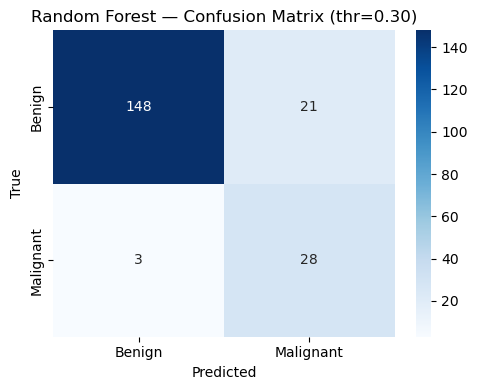

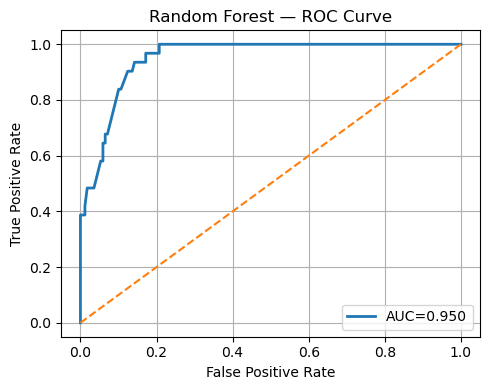

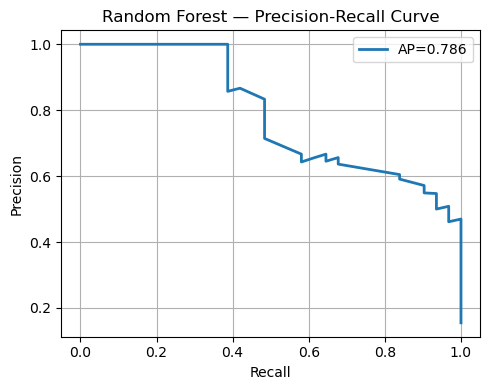

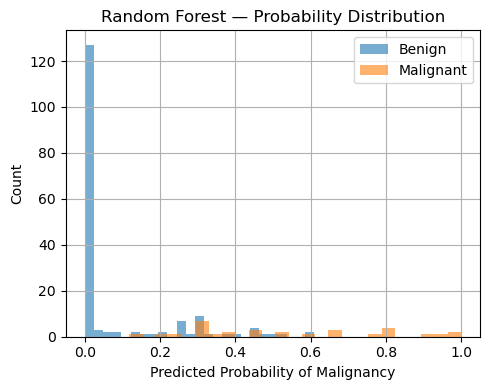

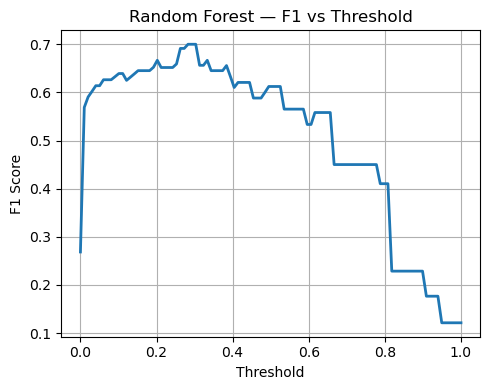

In [15]:
results = evaluate_clf(rf_model, X_test, y_test, threshold=0.30, title_prefix="Random Forest")


In [16]:
# %% [markdown]
# # Exports (no code above is changed)

# %%
import os, json
from pathlib import Path
import joblib

EXPORT_DIR = Path("model files")
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

# 1) Save the trained model (CalibratedClassifierCV wrapping your best RF)
model_path = EXPORT_DIR / "rf_model.joblib"
joblib.dump(rf_model, model_path)

# 2) Save the exact feature order used for training
#    (must match the columns seen by the model at fit time)
ref_columns = X.columns.tolist()
with open(EXPORT_DIR / "ref_columns.json", "w", encoding="utf-8") as f:
    json.dump(ref_columns, f, ensure_ascii=False, indent=2)

# 3) Save scaling info for numeric columns + one-hot settings
scaling_info = {
    "numeric": {
        "columns": num_cols,
        "mean": {c: float(m) for c, m in zip(num_cols, getattr(scaler, "mean_", [0.0]*len(num_cols)))},
        "scale": {c: float(s) for c, s in zip(num_cols, getattr(scaler, "scale_", [1.0]*len(num_cols)))},
        "scaler": "StandardScaler"
    },
    "one_hot": {
        "drop_first": True,
        "source_categorical_columns": ["Gender","Lifestyle","Ethnicity","Pre-existing Conditions"]
    },
    "mappings": {
        "Family_History_CRC": {"Yes": 1, "No": 0}
    },
    "target": "CRC_Risk"
}
with open(EXPORT_DIR / "scaling_info.json", "w", encoding="utf-8") as f:
    json.dump(scaling_info, f, ensure_ascii=False, indent=2)

# 4) Save target name
with open(EXPORT_DIR / "target_name.txt", "w", encoding="utf-8") as f:
    f.write("CRC_Risk\n")

print("Exported files:")
print(" -", model_path)
print(" -", EXPORT_DIR / "ref_columns.json")
print(" -", EXPORT_DIR / "scaling_info.json")
print(" -", EXPORT_DIR / "target_name.txt")


Exported files:
 - model files\rf_model.joblib
 - model files\ref_columns.json
 - model files\scaling_info.json
 - model files\target_name.txt
